# 02 Day Time Series LSTM Models with GPU
In this notebook, I will experiment with sequence data coming from just the 1-day timeframe. Specifically, I will experiment with the tf Keras functional API, along with testing the embeddings for sectors and such.

**Note**: This notebook differs from the previous notebook in that it uses the tf-metal environment (which is Apple's version of using the GPU on Mac). I found from the previous notebook that the GPU runs significantly faster than the CPU, and I've made the switch here.

Just to list out a few things I want to try out here:
 - Embeddings for different sectors
   - Make sure all sectors are represented properly
 - PCA, but with the proper data
 - Early callback

## Imports

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import heatmap
import dask
import dask.dataframe as dd
from dask import delayed
from pyarrow.parquet import ParquetFile
import pyarrow as pa
from tqdm import tqdm
import pydot
from IPython.display import display

import tulipy as ti

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Concatenate, LSTM, Dropout, Dense
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD
import keras_tuner as kt
from keras_tuner import HyperParameters

import os
import sys
import warnings

# Data Loading and Continued Feature Engineering for LSTM Model
I will start by loading in the ticker data with all the engineered features. I'll still do need to do some normalization, but that data is essentially fully ready to use.

Next, I'll re-mention the first two caveats I had in the previous notebook, one about selecting only the top 1,000 tickers by market cap, and the other about organizing their sectors:
1. I might only choose certain tickers, perhaps starting with the top 1,000 with the highest prices (or by market cap). To do that, I'll need to obtain a list of tickers with their market caps, that also matches the data that I have.
2. I will need to obtain a list of stocks with their respective sectors. Specifically, I want to reduce the number of stocks in the "Other" category as much as possible, and I want each of them to be well-defined.
   - There is the notion of trying to use the correlation between stocks (like I did with the MIDS 205 course) as potentially another predictive feature, but that's currently beyond the scope of what I'm trying to do here.
   - I will, however, try the embeddings strategy and see if they can learn anything about each other.
   - One more thing is that I could also try learning embeddings **from the tickers themselves** rather than just their sectors. That might actually provide even more support for certain tickers moving together, rather than just the correlation like I was using previously.
     - *This might only be possible/feasible when I learn about transformers, so perhaps not yet*

## Loading in the data after feature engineering
This is a direct continuation from the feature engineering step in the previous notebook.

In [2]:
# Loading in feature-engineered data from my SSD
FE_data_path = '/Volumes/T7/Data_For_ML_Modeling/Filtered_Cleaned_FE_Day_Data_2025_04_27.parquet'
data = pd.read_parquet(FE_data_path)

data

,Datetime,Open,High,Low,Close,Volume,PM_High,PM_Low,PM_Volume,Ticker,...,NATR_14,SMA_20,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Close_Chg_Amt,Prev_Pos_Neg_Vol,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT
2020-10-01,2020-10-01,117.70,117.720,115.8300,116.800,92076075.0,118.1000,116.5100,1755406.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2020-10-02,2020-10-02,112.84,115.370,112.2200,113.020,116084401.0,117.0800,112.5600,4460967.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,-3.780,0.0,0.0,NaN,NaN
2020-10-05,2020-10-05,113.92,116.650,113.5500,116.540,84421170.0,114.7100,113.3000,1690948.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,3.520,-116084401.0,-116084401.0,NaN,NaN
2020-10-06,2020-10-06,115.68,116.120,112.2500,113.160,132805466.0,116.7900,115.2300,1358666.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,-3.380,84421170.0,-31663231.0,NaN,NaN
2020-10-07,2020-10-07,114.64,115.550,114.1300,115.050,78303638.0,114.7500,113.1340,2071097.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,1.890,-132805466.0,-164468697.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04,2024-12-04,1.30,1.300,1.1800,1.180,3412081.0,1.3000,1.2800,18315.0,WW,...,7.785161,1.062825,1.401996,0.723654,1.398556,-0.110,1407225.0,164361463.0,85.446607,83.930629
2024-12-05,2024-12-05,1.21,1.210,1.0850,1.159,4859358.0,1.2300,1.1700,82055.0,WW,...,8.995157,1.065370,1.397785,0.732955,0.870178,-0.021,-3412081.0,160949382.0,69.074040,72.105997
2024-12-06,2024-12-06,1.15,1.370,1.1450,1.365,4244740.0,1.1799,1.1118,27760.0,WW,...,9.486626,1.069815,1.402207,0.737423,0.662382,0.206,-4859358.0,156090024.0,63.598326,62.337032
2024-12-09,2024-12-09,1.37,1.550,1.3591,1.430,6100859.0,1.3900,1.3500,17138.0,WW,...,8.458922,1.105585,1.467448,0.743722,1.516677,0.065,4244740.0,160334764.0,98.208848,85.092113


## Selecting top 1000 tickers based on market cap
I did this originally in the previous notebook, but I changed it after to include all tickers in my data. Now, I'll have to re-select the top 1000 tickers based on market cap.

In [3]:
# Getting a df of just the tickers and their respective market caps and then de-duping
df_mktcap = data[["Ticker", "Market_Cap"]].drop_duplicates()
df_mktcap = df_mktcap.sort_values(by="Market_Cap", ascending=False)

# Getting a list of the top 1000 tickers by market cap and filtering out our data for just those tickers
filtered_tickers = list(df_mktcap[:1000]["Ticker"])
df_1000 = data[data["Ticker"].isin(filtered_tickers)]

df_1000

,Datetime,Open,High,Low,Close,Volume,PM_High,PM_Low,PM_Volume,Ticker,...,NATR_14,SMA_20,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Close_Chg_Amt,Prev_Pos_Neg_Vol,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT
2020-10-01,2020-10-01,117.70,117.720,115.8300,116.80,92076075.0,118.10,116.510,1755406.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2020-10-02,2020-10-02,112.84,115.370,112.2200,113.02,116084401.0,117.08,112.560,4460967.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,-3.78,0.0,0.0,NaN,NaN
2020-10-05,2020-10-05,113.92,116.650,113.5500,116.54,84421170.0,114.71,113.300,1690948.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,3.52,-116084401.0,-116084401.0,NaN,NaN
2020-10-06,2020-10-06,115.68,116.120,112.2500,113.16,132805466.0,116.79,115.230,1358666.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,-3.38,84421170.0,-31663231.0,NaN,NaN
2020-10-07,2020-10-07,114.64,115.550,114.1300,115.05,78303638.0,114.75,113.134,2071097.0,AAPL,...,NaN,NaN,NaN,NaN,NaN,1.89,-132805466.0,-164468697.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04,2024-12-04,100.77,102.420,99.5000,99.51,154408.0,101.20,101.000,330.0,AXSM,...,3.414368,96.12925,103.277705,88.980795,1.418698,-1.07,223659.0,50718836.0,92.820283,72.905800
2024-12-05,2024-12-05,98.31,99.495,97.0600,98.22,131522.0,98.31,98.310,0.0,AXSM,...,3.496232,96.41225,102.979740,89.844760,0.577922,-1.29,-154408.0,50564428.0,64.454054,69.344391
2024-12-06,2024-12-06,98.31,100.240,98.1597,99.89,216298.0,98.38,97.510,200.0,AXSM,...,3.310527,96.79375,102.818540,90.768960,0.526574,1.67,-131522.0,50432906.0,65.059459,67.855856
2024-12-09,2024-12-09,100.21,102.300,97.5900,99.63,179608.0,99.99,99.990,100.0,AXSM,...,3.118623,97.36825,102.740347,91.996153,0.976062,-0.26,216298.0,50649204.0,78.983784,73.592793


## Selecting base features
Now, I'm going to select only the features I want to work with, and I explain my reasoning for each feature below.

In [4]:
df_1000.columns

Index(['Datetime', 'Open', 'High', 'Low', 'Close', 'Volume', 'PM_High',
       'PM_Low', 'PM_Volume', 'Ticker', 'PM_High_0927', 'PM_Low_0927',
       'PM_Close_0927', 'PM_Volume_0927', 'PM_High_0928', 'PM_Low_0928',
       'PM_Close_0928', 'PM_Volume_0928', 'Rank', 'Name', 'Sub_Industry_Orig',
       'Sub_Industry', 'Industry', 'Industry_Group', 'Sector', 'Market_Cap',
       'Close_Open_Diff', 'Close_Open_Diff_Perc', 'Close_Open_Diff_Binary',
       'Close_Open_Diff_Ternary', 'PDO', 'PDH', 'PDL', 'PDC', 'PDV',
       'PD_PM_V_0927', 'PD_PM_V_0928', 'Gap_from_PDC', 'Gap_Binary_Threshold',
       'Daily_Range_Gap_Up', 'DR_Gap_Up_Binary', 'Daily_Range_Gap_Down',
       'DR_Gap_Down_Binary', 'Avg_PM_Vol_Prev_14D', 'PM_Vol_Change',
       'SMA_Prev_14', 'SMA_Prev_50', 'EMA_Prev_9', 'EMA_Prev_20', 'RSI_14',
       'ATR_14', 'NATR_14', 'SMA_20', 'Upper_BBand', 'Lower_BBand',
       'Num_STD_from_SMA_20', 'Close_Chg_Amt', 'Prev_Pos_Neg_Vol', 'Prev_OBV',
       'Sto_Osc_K_RT', 'Sto_Osc_D_RT'],

In [5]:
# Getting a copy of the data to work with so we don't ruin original
data_small = df_1000.copy()

# If Rank is less than or equal to the number of NA_days, drop the row (since there will be NaN data)
NA_days = 50  # Choosing 50 for SMA_prev_50
data_small = data_small[data_small['Rank'] > NA_days]

# Since we used PM values to calculate PM_Vol_Change, there will be some NaNs or Inf (e.g., if there just wasn't any PM trading for that
# day). That is definitely somewhat unfortunate, since we likely wouldn't want to trade those stocks, but we'll include it in our data
# anyway. Therefore, we'll set the NaN and Inf values to 0
data_small['PM_Vol_Change'] = data_small['PM_Vol_Change'].replace([np.nan, np.inf, -np.inf], 0)

# Turning on the option to display all columns
pd.set_option('display.max_columns', None)

# Confirming that there are no NA values
data_small.isna().sum().sum()

np.int64(0)

Now I'm going to keep only a certain set of columns as my features. The reasons are as follow:
1. Helpful columns that won't be in my final data but are useful for organization:
   - **Datetime**, **Ticker**
2. Base price and volume features that will hopefully stabilize my model:
   - **PM_High_0928, PM_Low_0928, PM_Close_0928, PM_Volume_0928, PDO, PDH, PDL, PDC, PDV, Avg_PM_Vol_Prev_14D**
3. Gaps and % changes to keep track of how much a stock price/volume moved from the previous day:
   - **Gap_from_PDC, Gap_Binary_Threshold, Daily_Range_Gap_Up, DR_Gap_Up_Binary, Daily_Range_Gap_Down, DR_Gap_Down_Binary, PM_Vol_Change**
4. Only the **Industry** from the GICS Sectors and sub-sectors; the reasoning is because the industry seems granular enough to extract meaningful insights from embeddings, but not so specific as to create too much noise (though this may change later depending on model performance)
5. The **Market_Cap** might be a good gauge comparing bigger or smaller companies
6. Technical indicators that are derived from the base price and volume features:
   - SMAs/EMAs to identify potential stock momentum: **SMA_Prev_14, SMA_20, SMA_Prev_50, EMA_Prev_9, EMA_Prev_20**
   - Other technical indicators for volatility or price range: **RSI_14, NATR_14, Upper_BBand, Lower_BBand, Num_STD_from_SMA_20, Prev_OBV, Sto_Osc_K_RT, Sto_Osc_D_RT**
7. The outcome variable that I'll measure (just the **Close_Open_Diff_Ternary** for now, but potentially adding in the Close_Open_Diff_Perc later)

In [6]:
# Only keeping certain columns
data_small_columns_keep = ['Datetime', 'Ticker', 'PM_High_0928', 'PM_Low_0928', 'PM_Close_0928', 'PM_Volume_0928', 'PDO', 'PDH', 'PDL',
    'PDC', 'PDV', 'Avg_PM_Vol_Prev_14D', 'Gap_from_PDC', 'Gap_Binary_Threshold', 'Daily_Range_Gap_Up', 'DR_Gap_Up_Binary',
    'Daily_Range_Gap_Down', 'DR_Gap_Down_Binary', 'PM_Vol_Change', 'Industry', 'Market_Cap', 'SMA_Prev_14', 'SMA_20', 'SMA_Prev_50',
    'EMA_Prev_9', 'EMA_Prev_20', 'RSI_14', 'NATR_14', 'Upper_BBand', 'Lower_BBand', 'Num_STD_from_SMA_20', 'Prev_OBV', 'Sto_Osc_K_RT',
    'Sto_Osc_D_RT', 'Close_Open_Diff_Ternary']

data_small = data_small[data_small_columns_keep]

display(len(data_small_columns_keep))
display(data_small.describe())

35

,Datetime,PM_High_0928,PM_Low_0928,PM_Close_0928,PM_Volume_0928,PDO,PDH,PDL,PDC,PDV,Avg_PM_Vol_Prev_14D,Gap_from_PDC,Daily_Range_Gap_Up,Daily_Range_Gap_Down,PM_Vol_Change,Market_Cap,SMA_Prev_14,SMA_20,SMA_Prev_50,EMA_Prev_9,EMA_Prev_20,RSI_14,NATR_14,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT,Close_Open_Diff_Ternary
count,1005000,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06
mean,2022-12-11 20:42:16.119403008,1.407914e+02,1.402512e+02,1.405109e+02,2.832291e+04,1.404596e+02,1.422217e+02,1.386674e+02,1.404678e+02,2.628114e+06,2.834053e+04,4.949761e-04,1.368367e-03,-1.281908e-03,4.220245e+00,6.165581e+10,1.401747e+02,1.400841e+02,1.393350e+02,1.402890e+02,1.400394e+02,5.201304e+01,2.539780e+00,1.496446e+02,1.305236e+02,1.258969e-01,3.152249e+07,5.356921e+01,5.339563e+01,1.011695e+00
min,2020-12-11 00:00:00,7.141000e-01,6.801000e-01,7.141000e-01,0.000000e+00,6.665000e-01,7.798000e-01,2.500000e-01,6.890000e-01,0.000000e+00,0.000000e+00,-9.798976e-01,0.000000e+00,-9.794586e-01,-1.000000e+00,5.100000e+09,8.980857e-01,9.336600e-01,8.657880e-01,8.337746e-01,9.123886e-01,0.000000e+00,2.004522e-01,1.121882e+00,-2.005427e+03,-4.238944e+00,-1.796575e+09,0.000000e+00,0.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,4.015000e+01,3.990000e+01,4.000000e+01,0.000000e+00,4.000000e+01,4.053000e+01,3.946000e+01,4.000000e+01,2.960928e+05,7.671429e+01,-4.172989e-03,0.000000e+00,0.000000e+00,-1.000000e+00,9.007500e+09,3.998143e+01,3.999197e+01,3.982515e+01,4.000709e+01,4.000173e+01,3.980457e+01,1.740680e+00,4.274196e+01,3.710020e+01,-8.903576e-01,2.098938e+05,2.595231e+01,2.676511e+01,0.000000e+00
50%,2022-12-09 00:00:00,7.924000e+01,7.896000e+01,7.906000e+01,1.070000e+02,7.905000e+01,8.002000e+01,7.806000e+01,7.905000e+01,7.627325e+05,7.004286e+02,4.101162e-04,0.000000e+00,0.000000e+00,-7.664332e-01,1.807500e+10,7.893727e+01,7.888050e+01,7.854135e+01,7.901137e+01,7.890252e+01,5.206271e+01,2.232338e+00,8.403175e+01,7.375689e+01,2.129316e-01,9.011696e+06,5.579184e+01,5.562944e+01,1.000000e+00
75%,2023-12-11 00:00:00,1.548600e+02,1.541700e+02,1.545000e+02,2.950000e+03,1.544600e+02,1.564100e+02,1.524900e+02,1.545000e+02,2.073546e+06,5.876661e+03,5.295919e-03,0.000000e+00,0.000000e+00,0.000000e+00,4.770000e+10,1.540329e+02,1.539302e+02,1.531502e+02,1.542655e+02,1.540490e+02,6.437475e+01,2.952197e+00,1.640878e+02,1.438936e+02,1.142133e+00,3.429412e+07,8.172635e+01,8.046239e+01,2.000000e+00
max,2024-12-10 00:00:00,9.914170e+03,9.914170e+03,9.914170e+03,1.941779e+08,9.914170e+03,9.964770e+03,9.794000e+03,9.922590e+03,1.017757e+09,2.797966e+07,8.596639e+00,8.209677e+00,0.000000e+00,9.045258e+04,2.918340e+12,9.689424e+03,9.688178e+03,9.454171e+03,9.757990e+03,9.647032e+03,1.000000e+02,1.707141e+02,1.002093e+04,9.389099e+03,4.248141e+00,4.667864e+09,1.000000e+02,1.000000e+02,2.000000e+00
std,NaN,2.846837e+02,2.841613e+02,2.844219e+02,3.907997e+05,2.842312e+02,2.876188e+02,2.808455e+02,2.842836e+02,7.645709e+06,2.165459e+05,2.118239e-02,1.593568e-02,8.358116e-03,2.520952e+02,2.030093e+11,2.828645e+02,2.824058e+02,2.790687e+02,2.833161e+02,2.820280e+02,1.700931e+01,1.439189e+00,3.008494e+02,2.660835e+02,1.207081e+00,1.751612e+08,3.088682e+01,2.913905e+01,8.410857e-01


## EDA (Exploratory Data Analysis)
Now that I've selected my features, I'll see what they look like - and how correlated they are to the outcome variable - via EDA (Exploratory Data Analysis). The problem is that as of 4/28/25, my plan is to use the sliding window model like I did in 207, and I won't be doing so until a later step. Therefore, I won't be splitting my data right now, which technically means that I'll be looking at the test data. However, I believe I can get around this by assuming that the data (up till 2024-12-10) will be my **training** and **validation** data, and I'll generate new data (in 2025) as my "true" test data.

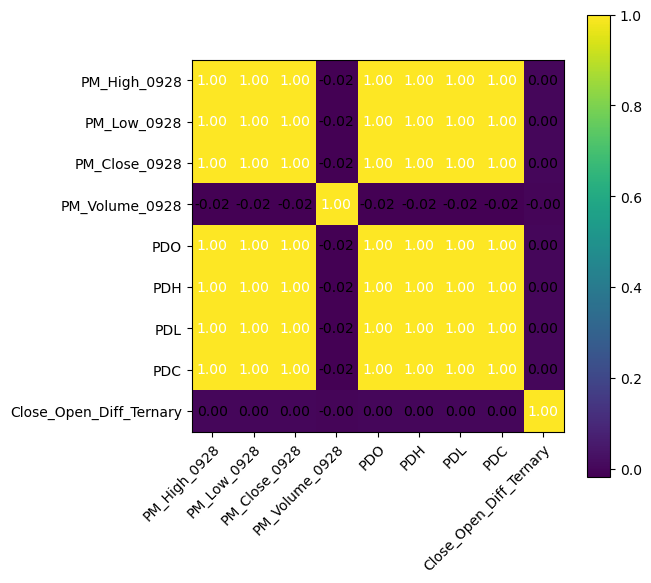

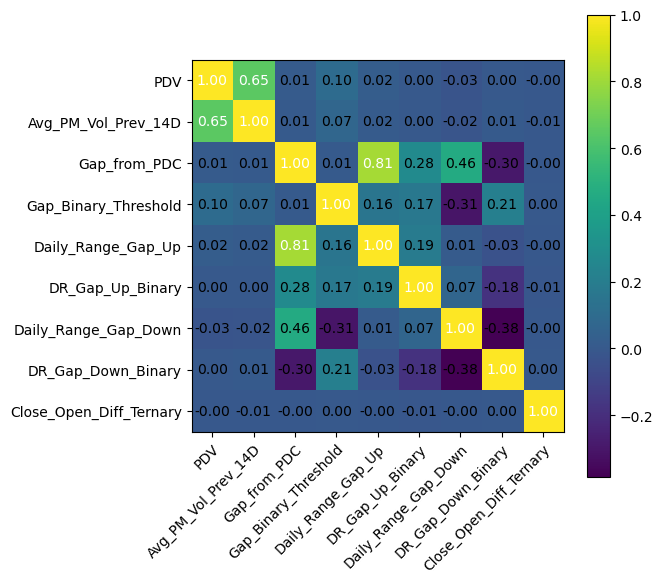

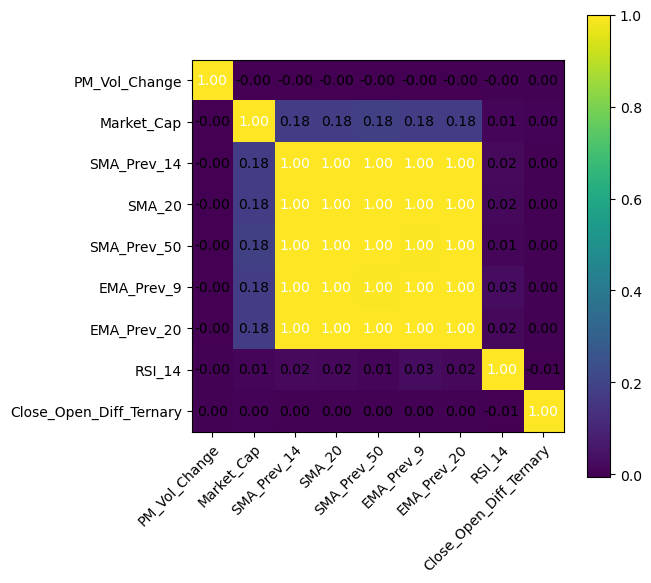

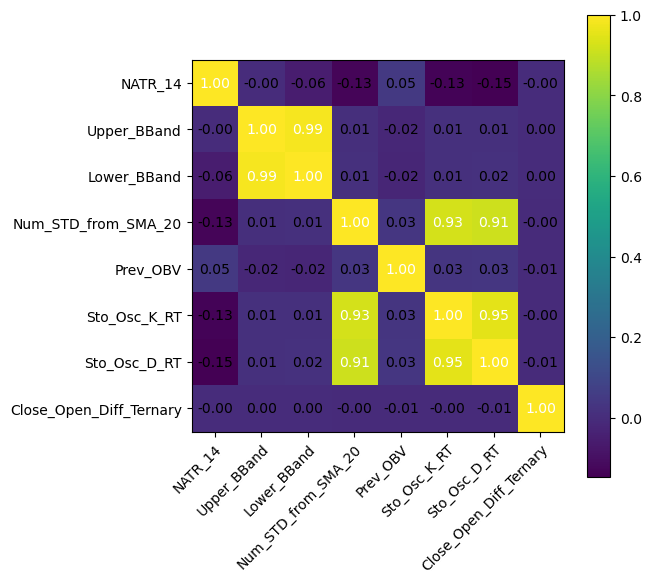

In [54]:
# Defining metric columns (need to split into multiple b/c too many) and a df_metric to analyze in our correlation matrix and heatmap
metric_cols_1 = ['PM_High_0928', 'PM_Low_0928', 'PM_Close_0928', 'PM_Volume_0928', 'PDO', 'PDH', 'PDL', 'PDC', 'Close_Open_Diff_Ternary']
metric_cols_2 = ['PDV', 'Avg_PM_Vol_Prev_14D', 'Gap_from_PDC', 'Gap_Binary_Threshold', 'Daily_Range_Gap_Up', 'DR_Gap_Up_Binary',
                 'Daily_Range_Gap_Down', 'DR_Gap_Down_Binary', 'Close_Open_Diff_Ternary']
metric_cols_3 = ['PM_Vol_Change', 'Market_Cap', 'SMA_Prev_14', 'SMA_20', 'SMA_Prev_50', 'EMA_Prev_9', 'EMA_Prev_20', 'RSI_14',
                 'Close_Open_Diff_Ternary']
metric_cols_4 = ['NATR_14', 'Upper_BBand', 'Lower_BBand', 'Num_STD_from_SMA_20', 'Prev_OBV', 'Sto_Osc_K_RT', 'Sto_Osc_D_RT',
                 'Close_Open_Diff_Ternary']
df_metric_1 = data_small[metric_cols_1]
df_metric_2 = data_small[metric_cols_2]
df_metric_3 = data_small[metric_cols_3]
df_metric_4 = data_small[metric_cols_4]

# Creating correlation matrices of the metric features and outcome variable
cm_1 = df_metric_1.corr().values
cm_2 = df_metric_2.corr().values
cm_3 = df_metric_3.corr().values
cm_4 = df_metric_4.corr().values

# Getting heatmaps based on the correlation matrices
hm_1 = heatmap(cm_1, row_names=metric_cols_1, column_names=metric_cols_1, figsize=(6, 6))
hm_2 = heatmap(cm_2, row_names=metric_cols_2, column_names=metric_cols_2, figsize=(6, 6))
hm_3 = heatmap(cm_3, row_names=metric_cols_3, column_names=metric_cols_3, figsize=(6, 6))
hm_4 = heatmap(cm_4, row_names=metric_cols_4, column_names=metric_cols_4, figsize=(6, 6))

plt.show()

While the heatmaps may not have been the most robust test, it does appear that there is pretty much no correlation between any of our features individually and our outcome variable. This clearly makes sense, as if there was a good predictor of stock price at the end of the day, we likely would've known about it by now.

**Note**: I then tried creating pairplots using sns.pairplot(). However, I had far too much data, and it would've taken an eternity to run. Therefore, I'm going to forgo showing the pairplots, but it's pretty safe to say that they don't look great (based on the results from our heatmap).

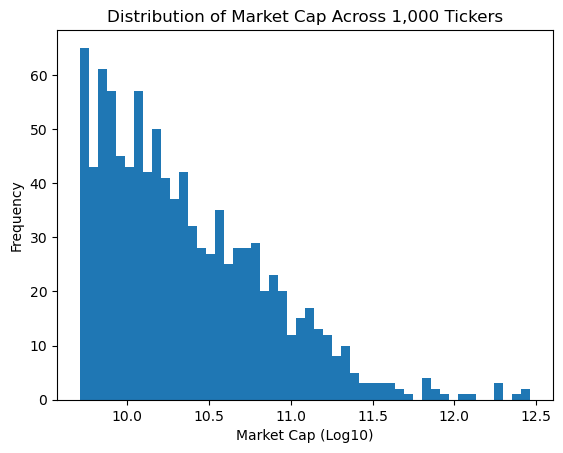

In [77]:
# Checking out the distribution of Market_Cap (to see if we need to perform a certain type of transform on it)
mkt_cap_unique = data_small.loc[:, ['Ticker', 'Market_Cap']].drop_duplicates()['Market_Cap']
mkt_cap_log = mkt_cap_unique.apply(np.log10)
plt.hist(mkt_cap_log, bins=50)
plt.xlabel("Market Cap (Log10)")
plt.ylabel("Frequency")
plt.title("Distribution of Market Cap Across 1,000 Tickers")
plt.show()

What we get from this is that the distribution of market cap within our data is pretty highly skewed. Performing a log10 transformation shows us that most tickers in our dataset have moderately-sized market caps, but there are a few giants out there with over $1 trillion in market cap. It might be wise to perform a log transformation on market cap to make the data scale better, and then divide by the average so we're in similar magnitudes as the other features.

## Normalizing the data
Now that I've selected the best features and found out what I needed to know from them, I'll now normalize the data to make the ML process go better (due to gradient descent working better for data that are not multiple magnitudes apart).

Before we normalize our data, we'll check some percent changes to make sure the differences between price and volume metrics stay the same. Basically, these comparison will be good litmus tests to confirm that our normalization worked properly (and that relative differences remain consistent).

In [7]:
# Getting some percent changes for the PDC compared to PDO for the first 5 values of data_small
display(data_small.iloc[0:5]['PDC'] / data_small.iloc[0:5]['PDO'])

# Getting some percent changes for the PM_Volume_0928 compared to Avg_PM_Vol_Prev_14D for the first 5 values of data_small
display(data_small.iloc[0:5]['PM_Volume_0928'] / data_small.iloc[0:5]['Avg_PM_Vol_Prev_14D'])

2020-12-11    1.022657
2020-12-14    1.000408
2020-12-15    0.993230
2020-12-16    1.027807
2020-12-17    1.002826
dtype: float64

2020-12-11    0.661908
2020-12-14    1.072553
2020-12-15    2.070033
2020-12-16    1.332927
2020-12-17    0.996049
dtype: float64

For the normalization itself, I originally planned on normalizing to the maximum of each ticker to preserve the same % changes as the unnormalized value (MinMax was also considered, but it messed with the percent changes between values, and I preferred to keep those intact). However, the drawback is that during inference, we may end up with values that go beyond the previous maximum, which our model has no training on.

Therefore, I'm changing the normalization to the **mean** of the values. This will increase the variance of course - as there's no limit to how large (or small) the values can get - which might affect how well the model is trained (since gradient descent works better with parameters that are closer in magnitude to each other. However, the hope is that the model will take that into account and learn based on that.

**Note for self**: One thing to research would be how to deal with outlier data, particularly in this context.

In [8]:
# Defining a function to normalize the prices/volume to the mean of every ticker
def normalize_to_mean_per_ticker(df, col_list):
    df_normalized = df.copy()

    # Grouping by Ticker and getting the mean values for either price or volume by ticker
    mean_vals = df_normalized.groupby('Ticker')[col_list].transform('mean').mean(axis=1)

    # Applying normalization to entire df by dividing by mean values for each ticker
    df_normalized[col_list] = df_normalized[col_list].div(mean_vals, axis=0)

    return df_normalized

Furthermore, I will normalize the columns to the **global** mean prices (by percent compared to mean price) for each ticker. For example, if the OHLC for a day is 2, 4, 1, 3, respectively, then their normalized versions would be 0.8, 1.6, 0.4, 1.2 (assuming that 2.5 was the global mean) overall. This will preserve long-term trends, and we can see how the price moves through multiple days of trading.

In [9]:
# Normalizing the following price columns to the global mean price for each ticker
price_cols_to_norm = ['PM_High_0928', 'PM_Low_0928', 'PM_Close_0928', 'PDO', 'PDH', 'PDL', 'PDC', 'SMA_Prev_14', 'SMA_20',
                      'SMA_Prev_50', 'EMA_Prev_9', 'EMA_Prev_20', 'Upper_BBand', 'Lower_BBand']
data_small = normalize_to_mean_per_ticker(data_small, price_cols_to_norm)

# Normalizing the following volume columns to the mean volume for each ticker
vol_cols_to_norm = ['PDV', 'Prev_OBV']
data_small = normalize_to_mean_per_ticker(data_small, vol_cols_to_norm)

# Normalizing the following PM volume columns to the mean PM volume for each ticker
PM_vol_cols_to_norm = ['PM_Volume_0928', 'Avg_PM_Vol_Prev_14D']
data_small = normalize_to_mean_per_ticker(data_small, PM_vol_cols_to_norm)

# Performing a log10 transform on market cap and then normalizing it to the average across all tickers
data_small['Market_Cap'] = data_small['Market_Cap'].apply(np.log10)
mkt_cap_norm_mean = data_small['Market_Cap'].mean()
data_small['Market_Cap'] = data_small['Market_Cap'] / mkt_cap_norm_mean

# Normalizing the following columns as percent (currently these are decimal changes) (except Vol_Change)
cols_to_perc = ['Gap_from_PDC', 'Daily_Range_Gap_Up', 'Daily_Range_Gap_Down']
data_small.loc[:, cols_to_perc] = data_small.loc[:, cols_to_perc] * 100

# Normalizing RSI and Stochastic Oscillators to be between 0 and 1
norm_to_0_1_cols = ['RSI_14', 'Sto_Osc_K_RT', 'Sto_Osc_D_RT']
data_small.loc[:, norm_to_0_1_cols] = data_small.loc[:, norm_to_0_1_cols] / 100

data_small.describe()

,Datetime,PM_High_0928,PM_Low_0928,PM_Close_0928,PM_Volume_0928,PDO,PDH,PDL,PDC,PDV,Avg_PM_Vol_Prev_14D,Gap_from_PDC,Daily_Range_Gap_Up,Daily_Range_Gap_Down,PM_Vol_Change,Market_Cap,SMA_Prev_14,SMA_20,SMA_Prev_50,EMA_Prev_9,EMA_Prev_20,RSI_14,NATR_14,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT,Close_Open_Diff_Ternary
count,1005000,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06,1.005000e+06
mean,2022-12-11 20:42:16.119403008,1.004941e+00,9.992777e-01,1.001968e+00,1.002400e+00,1.001551e+00,1.014492e+00,9.883986e-01,1.001550e+00,3.714502e-01,9.975996e-01,4.949761e-02,1.368367e-01,-1.281908e-01,4.220245e+00,1.000000e+00,9.994362e-01,9.987800e-01,9.932101e-01,1.000261e+00,9.985751e-01,5.201304e-01,2.539780e+00,1.067952e+00,9.296082e-01,1.258969e-01,1.628550e+00,5.356921e-01,5.339563e-01,1.011695e+00
min,2020-12-11 00:00:00,1.825898e-02,1.712466e-02,1.777314e-02,0.000000e+00,1.774357e-02,2.086982e-02,1.337504e-02,1.822518e-02,-1.076030e+03,0.000000e+00,-9.798976e+01,0.000000e+00,-9.794586e+01,-1.000000e+00,9.367940e-01,2.452234e-02,2.511328e-02,2.818980e-02,2.384866e-02,2.626187e-02,0.000000e+00,2.004522e-01,2.991754e-02,-2.285838e+00,-4.238944e+00,-1.205840e+04,0.000000e+00,0.000000e+00,0.000000e+00
25%,2021-12-10 00:00:00,8.468480e-01,8.424594e-01,8.445280e-01,0.000000e+00,8.442980e-01,8.556579e-01,8.330539e-01,8.444797e-01,1.790728e-02,1.139908e-01,-4.172989e-01,0.000000e+00,0.000000e+00,-1.000000e+00,9.606331e-01,8.448385e-01,8.452586e-01,8.453215e-01,8.452334e-01,8.463056e-01,3.980457e-01,1.740680e+00,9.017239e-01,7.834865e-01,-8.903576e-01,9.125037e-01,2.595231e-01,2.676511e-01,0.000000e+00
50%,2022-12-09 00:00:00,9.782028e-01,9.741750e-01,9.760667e-01,4.295646e-02,9.758167e-01,9.868579e-01,9.646243e-01,9.759745e-01,5.260811e-02,3.748150e-01,4.101162e-02,0.000000e+00,0.000000e+00,-7.664332e-01,9.898223e-01,9.747213e-01,9.745256e-01,9.710056e-01,9.751970e-01,9.742674e-01,5.206271e-01,2.232338e+00,1.031503e+00,9.159943e-01,2.129316e-01,1.915977e+00,5.579184e-01,5.562944e-01,1.000000e+00
75%,2023-12-11 00:00:00,1.120376e+00,1.115218e+00,1.117681e+00,4.352856e-01,1.117353e+00,1.129781e+00,1.104418e+00,1.117219e+00,1.188400e-01,9.257809e-01,5.295919e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.030492e+00,1.113715e+00,1.112682e+00,1.104888e+00,1.114572e+00,1.111487e+00,6.437475e-01,2.952197e+00,1.181206e+00,1.048267e+00,1.142133e+00,2.902093e+00,8.172635e-01,8.046239e-01,2.000000e+00
max,2024-12-10 00:00:00,7.061103e+00,6.280767e+00,6.548334e+00,9.549454e+02,6.516145e+00,6.817912e+00,5.819703e+00,6.421592e+00,3.243786e+03,6.821038e+01,8.596639e+02,8.209677e+02,0.000000e+00,9.045258e+04,1.202903e+00,5.716735e+00,5.660247e+00,5.215130e+00,5.764834e+00,5.554490e+00,1.000000e+00,1.707141e+02,7.360601e+00,5.348269e+00,4.248141e+00,8.463608e+03,1.000000e+00,1.000000e+00,2.000000e+00
std,NaN,3.019156e-01,2.988639e-01,3.003107e-01,9.205163e+00,3.000320e-01,3.048085e-01,2.948117e-01,2.997334e-01,1.648744e+01,2.631630e+00,2.118239e+00,1.593568e+00,8.358116e-01,2.520952e+02,4.843146e-02,2.953817e-01,2.938447e-01,2.860736e-01,2.961073e-01,2.918879e-01,1.700931e-01,1.439189e+00,3.283147e-01,2.753175e-01,1.207081e+00,1.661748e+02,3.088682e-01,2.913905e-01,8.410857e-01


In [10]:
# Double checking data_small shows us that we do indeed keep % differences between price features on the same day even after normalization
display(data_small.iloc[0:5]['PDC'] / data_small.iloc[0:5]['PDO'])

# And we see that we also keep % differences between the two PM volume features on the same day after normalization
display(data_small.iloc[0:5]['PM_Volume_0928'] / data_small.iloc[0:5]['Avg_PM_Vol_Prev_14D'])

2020-12-11    1.022657
2020-12-14    1.000408
2020-12-15    0.993230
2020-12-16    1.027807
2020-12-17    1.002826
dtype: float64

2020-12-11    0.661908
2020-12-14    1.072553
2020-12-15    2.070033
2020-12-16    1.332927
2020-12-17    0.996049
dtype: float64

Now that we have our normalized features, the only thing left to transform is the "Industry" column. Because I'm planning on using embeddings, I will start the process by label-encoding that column by mapping each industry to a unique integer.

In [11]:
# Encoding the industry by getting their respective Industry IDs
le = LabelEncoder()
data_small['Industry_ID'] = le.fit_transform(data_small['Industry'])

data_small.head()

,Datetime,Ticker,PM_High_0928,PM_Low_0928,PM_Close_0928,PM_Volume_0928,PDO,PDH,PDL,PDC,PDV,Avg_PM_Vol_Prev_14D,Gap_from_PDC,Gap_Binary_Threshold,Daily_Range_Gap_Up,DR_Gap_Up_Binary,Daily_Range_Gap_Down,DR_Gap_Down_Binary,PM_Vol_Change,Industry,Market_Cap,SMA_Prev_14,SMA_20,SMA_Prev_50,EMA_Prev_9,EMA_Prev_20,RSI_14,NATR_14,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT,Close_Open_Diff_Ternary,Industry_ID
2020-12-11,2020-12-11,AAPL,0.738878,0.729927,0.735874,0.785821,0.723859,0.744165,0.721816,0.740260,-1.412617,1.187205,-0.592436,False,0.000000,False,0.0,False,-0.338092,Household Durables,1.202903,0.721724,0.720908,0.706568,0.733054,0.722589,0.626036,2.180768,0.758621,0.683195,0.793704,2.371272,0.741018,0.738772,1,33
2020-12-14,2020-12-14,AAPL,0.740500,0.733471,0.736835,1.299306,0.735574,0.737496,0.724219,0.735874,-1.473669,1.211414,0.130623,False,0.000000,False,0.0,False,0.072553,Household Durables,1.202903,0.723943,0.721929,0.707252,0.733618,0.723854,0.754498,2.064892,0.760231,0.683627,0.778366,3.844941,0.752994,0.763224,0,33
2020-12-15,2020-12-15,AAPL,0.747889,0.732930,0.747289,2.538753,0.736535,0.741041,0.730167,0.731549,-1.197427,1.226432,2.151597,True,0.843129,True,0.0,False,1.070033,Household Durables,1.202903,0.727328,0.722878,0.708303,0.733204,0.724587,0.741109,2.082967,0.762515,0.683241,1.231706,5.042368,0.855288,0.761144,2,33
2020-12-16,2020-12-16,AAPL,0.773182,0.762248,0.765612,1.674937,0.747529,0.768375,0.745727,0.768315,-2.764059,1.256586,-0.351865,False,0.000000,False,0.0,False,0.332927,Household Durables,1.202903,0.732787,0.726357,0.709667,0.740227,0.728752,0.756976,2.055338,0.773332,0.679381,1.671315,2.278309,0.899038,0.861793,1,33
2020-12-17,2020-12-17,AAPL,0.777387,0.766513,0.774383,1.293692,0.765312,0.771199,0.760325,0.767474,-1.659911,1.298824,0.900196,False,0.412869,True,0.0,False,-0.003951,Household Durables,1.202903,0.737820,0.729724,0.711420,0.745676,0.732440,0.775028,2.087224,0.780831,0.678617,1.747686,3.938220,0.960286,0.969491,1,33


In [12]:
# Ordering by date, and then by ticker to get the right splits for train/val/test
data_small = data_small.sort_values(by=['Datetime', 'Ticker'])
data_small.shape

(1005000, 36)

# LSTM Base Model (7 test days)
This LSTM model is simply a proof-of-concept to 1) confirm that the Keras Functional API is useable and 2) make sure the embeddings work with the data. I'll use 7 test days at the end, and I'll alter the sequence length, number of LSTM layers, number of LSTM units, and number of dropout layers.

## Generating X continuous series sequences, X Industry_ID features, and Y continuous labels for LSTM model
Here, I generate the X series sequences and respective Y continuous labels, ordered first by the date, and then by the ticker. I also generate the Industry_ID features to be used in embeddings layers on.

The following is the updated function used to create the respective X and Y sequences in the LSTM model:

In [13]:
# Function for creating sequences (with embeddings) for LSTM model
def create_sequences_with_embeddings(df, seq_length, group_col, target_col, drop_cols, embedding_cols):
    """
    Create LSTM sequences with both numeric features and embedding inputs.

    Parameters:
        df: DataFrame with time series data
        seq_length: length of each input sequence
        group_col: column name to group sequences by (e.g., 'Ticker')
        target_col: name of the target (label) column
        drop_cols: list of columns to drop (e.g., Datetime or Date_col, unused metrics)
        embedding_cols: list of categorical columns to embed (e.g., ['Industry_ID'])

    Returns:
        X_numeric: shape (samples, seq_length, num_numeric_features)
        X_embeddings: list of arrays, one per embedding column, each shape (samples, seq_length)
        Y: (samples,)
    """
   
    X_numeric, Y = [], []
    X_embeddings = [[] for _ in embedding_cols]
    num_tickers = df[group_col].nunique()
    
    # Group data by unique time series identifier (i.e., 'Ticker')
    grouped = df.groupby(group_col)
    
    for _, group in tqdm(grouped):
        # Sorting by Date_col and removing the 'Ticker' column and dropped columns
        group = group.sort_values(by='Datetime')
        
        # Separating out the target and embedded columns
        labels = group[target_col].values
        embed_data = [group[col].values for col in embedding_cols]

        # Dropping group_col, target_col, embedding_cols, and drop_cols to isolate numeric features
        exclude = drop_cols + [group_col, target_col] + embedding_cols
        feature_cols = group.drop(columns=exclude).columns
        feature_data = group[feature_cols].values

        # Creating sequences for this group only
        for i in range(len(group) - seq_length + 1):
            X_numeric.append(feature_data[i:i+seq_length])  # Collecting seq_length time steps of metric features
            for j, col_values in enumerate(embed_data):
                X_embeddings[j].append(col_values[i:i+seq_length])  # Collecting seq_length time steps of embedding cols
            Y.append(labels[i+seq_length-1])  # Target label is the most recent time step
    print("Creating grouped sequences complete.")
    
    # Convert to numpy arrays and the correct dtypes
    X_numeric = np.array(X_numeric).astype(np.float32)
    X_embeddings = [np.array(embed).astype(np.int32) for embed in X_embeddings]
    Y = np.array(Y).astype(np.int32)
    print("Conversion to np arrays and appropriate dtypes complete.")
    
    # Re-ordering data first by the date, and then by the ticker
    indices_by_date_then_ticker = np.arange(X_numeric.shape[0]).reshape((num_tickers, -1)).flatten('F')
    X_numeric = X_numeric[indices_by_date_then_ticker]
    X_embeddings = [x[indices_by_date_then_ticker] for x in X_embeddings]
    Y = Y[indices_by_date_then_ticker]
    print("Re-ordering complete.")
    
    return X_numeric, X_embeddings, Y

In [14]:
# Creating sequences for LSTM model
seq_length = 50
group_col = 'Ticker'
target_col = 'Close_Open_Diff_Ternary'
drop_cols = ['Datetime', 'Industry']
embedding_cols = ['Industry_ID']

X_data_small_num, X_data_small_embed, Y_data_small = create_sequences_with_embeddings(
    data_small, seq_length, group_col, target_col, drop_cols, embedding_cols)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1100.54it/s]


Creating grouped sequences complete.
Conversion to np arrays and appropriate dtypes complete.
Re-ordering complete.


In [15]:
# Confirming shapes
print('Shape of X_data_small_num:', X_data_small_num.shape)
for idx, embed_col in enumerate(embedding_cols):
    print('Shape of col', idx+1, 'in X_data_small_embed:', X_data_small_embed[idx].shape)
print('Shape of Y_data_small:', Y_data_small.shape, '\n')

# Confirming that we should have the correct number of sequences in X_data_small_num
unique_tickers = data_small['Ticker'].nunique()
unique_dates = data_small['Datetime'].nunique()
expected_num_sequences = unique_tickers * (unique_dates - seq_length + 1)

print('Number of unique tickers in data_small:', unique_tickers)
print('Number of unique dates in data_small:', unique_dates)
print('Chosen sequence length:', seq_length)
print('Number of sequences assuming the above seq_length:', unique_dates - seq_length + 1)
print('(We need to add 1 to the end to account for either the beginning or the end. For example, if we had 12 observations with a window')
print('of 5, we would need 12 - 5 + 1 = 8 sequences, the first one being having indices from [0:5], and the last from [7:12].)\n')
print('Total number of data sequences expected:', expected_num_sequences)
print('Total number of data sequences achieved:', X_data_small_num.shape[0])

Shape of X_data_small_num: (956000, 50, 31)
Shape of col 1 in X_data_small_embed: (956000, 50)
Shape of Y_data_small: (956000,) 

Number of unique tickers in data_small: 1000
Number of unique dates in data_small: 1005
Chosen sequence length: 50
Number of sequences assuming the above seq_length: 956
(We need to add 1 to the end to account for either the beginning or the end. For example, if we had 12 observations with a window
of 5, we would need 12 - 5 + 1 = 8 sequences, the first one being having indices from [0:5], and the last from [7:12].)

Total number of data sequences expected: 956000
Total number of data sequences achieved: 956000


### Confirming that the data is correct
I'll check that the data in my numpy sequences is correct by comparing them with the feature values in my original dataset.

In [192]:
# Displaying the first and last features of data_small for comparison
display(data_small.head(2))
display(data_small.tail(3))

,Datetime,Ticker,PM_High_0928,PM_Low_0928,PM_Close_0928,PM_Volume_0928,PDO,PDH,PDL,PDC,PDV,Avg_PM_Vol_Prev_14D,Gap_from_PDC,Gap_Binary_Threshold,Daily_Range_Gap_Up,DR_Gap_Up_Binary,Daily_Range_Gap_Down,DR_Gap_Down_Binary,PM_Vol_Change,Industry,Market_Cap,SMA_Prev_14,SMA_20,SMA_Prev_50,EMA_Prev_9,EMA_Prev_20,RSI_14,NATR_14,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT,Close_Open_Diff_Ternary,Industry_ID
2020-12-11,2020-12-11,A,0.871062,0.871062,0.871062,0.168628,0.863237,0.885087,0.858771,0.877041,0.053561,1.54300,-0.681761,False,0.0,False,0.0,False,-0.890714,Health Care Equipment & Supplies,1.010053,0.848030,0.838338,0.801941,0.854621,0.903423,0.685834,2.451754,0.887846,0.788830,1.321958,0.541987,0.816248,0.847837,1,28
2020-12-11,2020-12-11,AA,0.576723,0.568998,0.570446,0.400607,0.546185,0.581744,0.543891,0.579620,0.042201,0.46832,-1.582674,False,0.0,False,0.0,False,-0.144587,Metals & Mining,0.946960,0.523492,0.503347,0.387817,0.543969,0.517114,0.731589,4.461831,0.612928,0.393766,1.224653,0.790086,0.890467,0.871965,0,45


,Datetime,Ticker,PM_High_0928,PM_Low_0928,PM_Close_0928,PM_Volume_0928,PDO,PDH,PDL,PDC,PDV,Avg_PM_Vol_Prev_14D,Gap_from_PDC,Gap_Binary_Threshold,Daily_Range_Gap_Up,DR_Gap_Up_Binary,Daily_Range_Gap_Down,DR_Gap_Down_Binary,PM_Vol_Change,Industry,Market_Cap,SMA_Prev_14,SMA_20,SMA_Prev_50,EMA_Prev_9,EMA_Prev_20,RSI_14,NATR_14,Upper_BBand,Lower_BBand,Num_STD_from_SMA_20,Prev_OBV,Sto_Osc_K_RT,Sto_Osc_D_RT,Close_Open_Diff_Ternary,Industry_ID
2024-12-10,2024-12-10,ZS,1.091496,1.085692,1.085692,0.075046,1.127431,1.143472,1.080362,1.087908,0.051033,2.689115,-0.203715,False,0.0,False,0.00000,False,-0.972093,IT Services,1.012955,1.090494,1.089842,1.021004,1.090233,1.076236,0.512927,3.512874,1.128132,1.051552,-0.216776,3.068209,0.503626,0.609256,0,35
2024-12-10,2024-12-10,ZTO,0.749205,0.718310,0.722172,1.411313,0.759246,0.768129,0.746116,0.748819,0.321691,0.645900,-3.558535,True,0.0,False,-3.20911,True,1.185035,Air Freight & Logistics,0.981951,0.743399,0.758049,0.877860,0.737399,0.768832,0.272374,2.747734,0.830079,0.686019,-0.996163,-1.028335,0.094170,0.134917,2,1
2024-12-10,2024-12-10,ZTS,0.998781,0.998781,0.998781,0.000000,0.987552,1.009466,0.983060,1.000690,-0.209428,0.129167,-0.190775,False,0.0,False,0.00000,False,-1.000000,Consumer Staples Distribution & Retail,1.043757,0.990690,0.989698,1.022479,0.991136,0.994137,0.576421,1.793446,1.003414,0.975981,1.324458,5.048430,0.541667,0.514093,0,14


In [182]:
# Confirming that the first few embeddings are correct in the embedding data
X_data_small_industry = X_data_small_embed[0]
X_data_small_industry[:2]

array([[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
        28, 28],
       [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45]], dtype=int32)

In [186]:
# Confirming that the first few sequences are correct for the numeric features in X_data_small_num
display(X_data_small_num[0, 0])
display(X_data_small_num[1, 0])

array([ 0.8710616 ,  0.8710616 ,  0.8710616 ,  0.16862842,  0.86323684,
        0.8850872 ,  0.8587708 ,  0.877041  ,  0.05356135,  1.5430003 ,
       -0.6817608 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.89071393,  1.0100529 ,  0.8480302 ,  0.8383378 ,
        0.8019407 ,  0.85462064,  0.90342283,  0.68583375,  2.4517536 ,
        0.88784593,  0.7888296 ,  1.3219584 ,  0.5419868 ,  0.8162476 ,
        0.8478373 ], dtype=float32)

array([ 0.5767227 ,  0.5689977 ,  0.57044613,  0.4006071 ,  0.54618466,
        0.58174396,  0.54389125,  0.5796196 ,  0.04220112,  0.46831986,
       -1.5826739 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.14458656,  0.9469598 ,  0.52349234,  0.50334686,
        0.3878174 ,  0.54396933,  0.51711434,  0.73158914,  4.4618316 ,
        0.6129277 ,  0.39376608,  1.2246532 ,  0.7900858 ,  0.8904665 ,
        0.87196535], dtype=float32)

In [191]:
# Confirming that the first Y labels are the same in the sequences and the original data (which starts on day 50 for day 50's prediction)
display(data_small[49000:49005]['Close_Open_Diff_Ternary'])
display(Y_data_small[:5])

2021-02-24    2
2021-02-24    2
2021-02-24    2
2021-02-24    2
2021-02-24    1
Name: Close_Open_Diff_Ternary, dtype: int64

array([2, 2, 2, 2, 1], dtype=int32)

In [193]:
# Confirming the last Y labels are also the same
Y_data_small[-3:]

array([0, 2, 0], dtype=int32)

Now that I've confirmed that I created my sequences properly, I can move onto actually building the model.

## Defining functions for splitting the dataset and building/compiling the LSTM model

I use the following function to constantly generate new training, validation, and test data splits. The validation split will be 0 for now, but it's helpful to have this function for defining it later if we want to implement our sliding window functionality down the line.

In [16]:
# Defining function to split sequence data into train, val, test splits with split size (in terms of # of days)
def train_val_test_seq_split(data_window, num_tickers, train_size, val_size, test_size):
    df = data_window.copy()

    if (df.shape[0]/num_tickers) != (train_size + val_size + test_size):
        print("Train + val + test sizes do not much number of dates")
        return None

    df_train = df[:(num_tickers * train_size)]
    df_val = df[(num_tickers * train_size):(num_tickers * (train_size + val_size))]
    df_test = df[(num_tickers * (train_size + val_size)):]

    return df_train, df_val, df_test

In [17]:
# Setting initial parameters for splits
num_sequences_per_ticker = unique_dates - seq_length + 1  # unique_dates is from above
test_size = 7
val_size = 0
train_size = num_sequences_per_ticker - test_size
X_data_small_industry = X_data_small_embed[0]

# Performing the data splits with my X_data_small_num, X_data_small_embed, and Y_data_small
X_num_train, _, X_num_test = train_val_test_seq_split(X_data_small_num, unique_tickers, train_size, val_size, test_size)
X_embed_train, _, X_embed_test = train_val_test_seq_split(X_data_small_industry, unique_tickers, train_size, val_size, test_size)
Y_train, _, Y_test = train_val_test_seq_split(Y_data_small, unique_tickers, train_size, val_size, test_size)

print("X_num_train shape:", X_num_train.shape)
print("X_num_test shape:", X_num_test.shape)
print("X_embed_train shape:", X_embed_train.shape)
print("X_embed_test shape:", X_embed_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_num_train shape: (949000, 50, 31)
X_num_test shape: (7000, 50, 31)
X_embed_train shape: (949000, 50)
X_embed_test shape: (7000, 50)
Y_train shape: (949000,)
Y_test shape: (7000,)


I use the following function to build, compile, and run my LSTM model using X_num_train, X_embed_train, and Y_train:

In [22]:
# Defining a function to create the LSTM model using the Keras functional API along with embeddings
def build_LSTM_model_func_API_embed(seq_length,
                                    num_features,  # Excluding Industry
                                    n_classes,
                                    num_industries,
                                    embedding_dim=5,
                                    LSTM_layers=1,
                                    LSTM_units=128,
                                    dropout_rate=0.3,
                                    hidden_layer_sizes=[],
                                    activation='relu',
                                    learning_rate=0.0001,
                                    optimizer='Adam',
                                    metric='accuracy'):

    # Resetting tf for consistent results
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Getting the Input features
    features_input = Input(shape=(seq_length, num_features), name='Features_Input')
    industry_input = Input(shape=(seq_length,), dtype='int32', name='Industry_Input')

    # Getting the embedding for Industry
    industry_embedded = Embedding(input_dim=num_industries, output_dim=embedding_dim, name='Industry_Embedding')(industry_input)

    # Concatenating embedded industry with features (shape: (batch, seq_length, num_features + embedding_dim))
    x = Concatenate(axis=-1, name='Feature_Concat')([features_input, industry_embedded])

    # Getting the LSTM and Dropout layers
    for i in range(LSTM_layers):
        
        LSTM_return_sequences = True
        if i + 1 == LSTM_layers:
            LSTM_return_sequences = False
        
        LSTM_layer_name = 'LSTM' + str(i)
        x = LSTM(units=LSTM_units, return_sequences=LSTM_return_sequences, name=LSTM_layer_name)(x)

        LSTM_dropout_name = 'Dropout' + str(i)
        x = Dropout(dropout_rate, name=LSTM_dropout_name)(x)

    # Adding in hidden layers and dropout layers
    for idx, hidden_layer_size in enumerate(hidden_layer_sizes):
        hidden_layer_name = 'Hidden' + str(idx)
        x = Dense(units=hidden_layer_size, activation=activation, name=hidden_layer_name)(x)
        HL_dropout_name = 'HL_Dropout' + str(idx)
        x = Dropout(dropout_rate, name=HL_dropout_name)(x)
    
    # Finishing with the output layer
    output = Dense(units=n_classes, activation='softmax', name='Output')(x)

    model = tf.keras.Model(inputs=[features_input, industry_input], outputs=output, name='LSTM_Embed')
    
    # Compiling the model
    optimizer_class = getattr(tf.keras.optimizers, optimizer)
    optimizer_instance = optimizer_class(learning_rate=learning_rate)
    model.compile(optimizer=optimizer_instance,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=[metric])
    
    return model

## Running the base LSTM model with 7 test days
We'll run through our entire dataset to get a baseline measure of how well our model performs.

In [19]:
# Setting seed for consistent re-runs
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting hyperparameters
seq_length = X_data_small_num.shape[1]
num_features = X_data_small_num.shape[2]
n_classes = 3
num_industries = data_small['Industry_ID'].nunique()
embedding_dim = 5
LSTM_layers = 1
LSTM_units = 128
dropout_rate = 0.3
hidden_layer_sizes = []
activation = 'relu'
learning_rate = 0.0001
optimizer = 'Adam'
metric = 'accuracy'
num_epochs = 10
batch_size = 256

In [20]:
# Building the initial model
model_LSTM_base = build_LSTM_model_func_API_embed(seq_length=seq_length,
                                                  num_features=num_features,
                                                  n_classes=n_classes,
                                                  num_industries=num_industries,
                                                  embedding_dim=embedding_dim,
                                                  LSTM_layers=LSTM_layers,
                                                  LSTM_units=LSTM_units,
                                                  dropout_rate=dropout_rate,
                                                  hidden_layer_sizes=hidden_layer_sizes,
                                                  activation=activation,
                                                  learning_rate=learning_rate,
                                                  optimizer=optimizer,
                                                  metric=metric)
model_LSTM_base.summary()

2025-05-01 10:19:18.343756: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Max
2025-05-01 10:19:18.343932: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2025-05-01 10:19:18.343942: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.00 GB
I0000 00:00:1746109158.343956 6225192 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1746109158.343971 6225192 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "Base_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Industry_Input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Features_Input      │ (None, 50, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Industry_Embedding  │ (None, 50, 5)     │        330 │ Industry_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Feature_Concat      │ (None, 50, 36)    │          0 │ Features_Input[0… │
│ (Concatenate)       │                   │            │ Industry_Embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM0 (LSTM)        │ (None, 128)       │     84,480 │ Feature_Concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout0 (Dropout)  │ (None, 128)       │          0 │ LSTM0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 3)         │        387 │ Dropout0[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 85,197 (332.80 KB)

 Trainable params: 85,197 (332.80 KB)

 Non-trainable params: 0 (0.00 B)

Again, the reason I'm getting the warnings above is because I'm using the GPU from the M4 Max using the metal plugin.

In [24]:
# Confirming that I'm still only using CPU
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


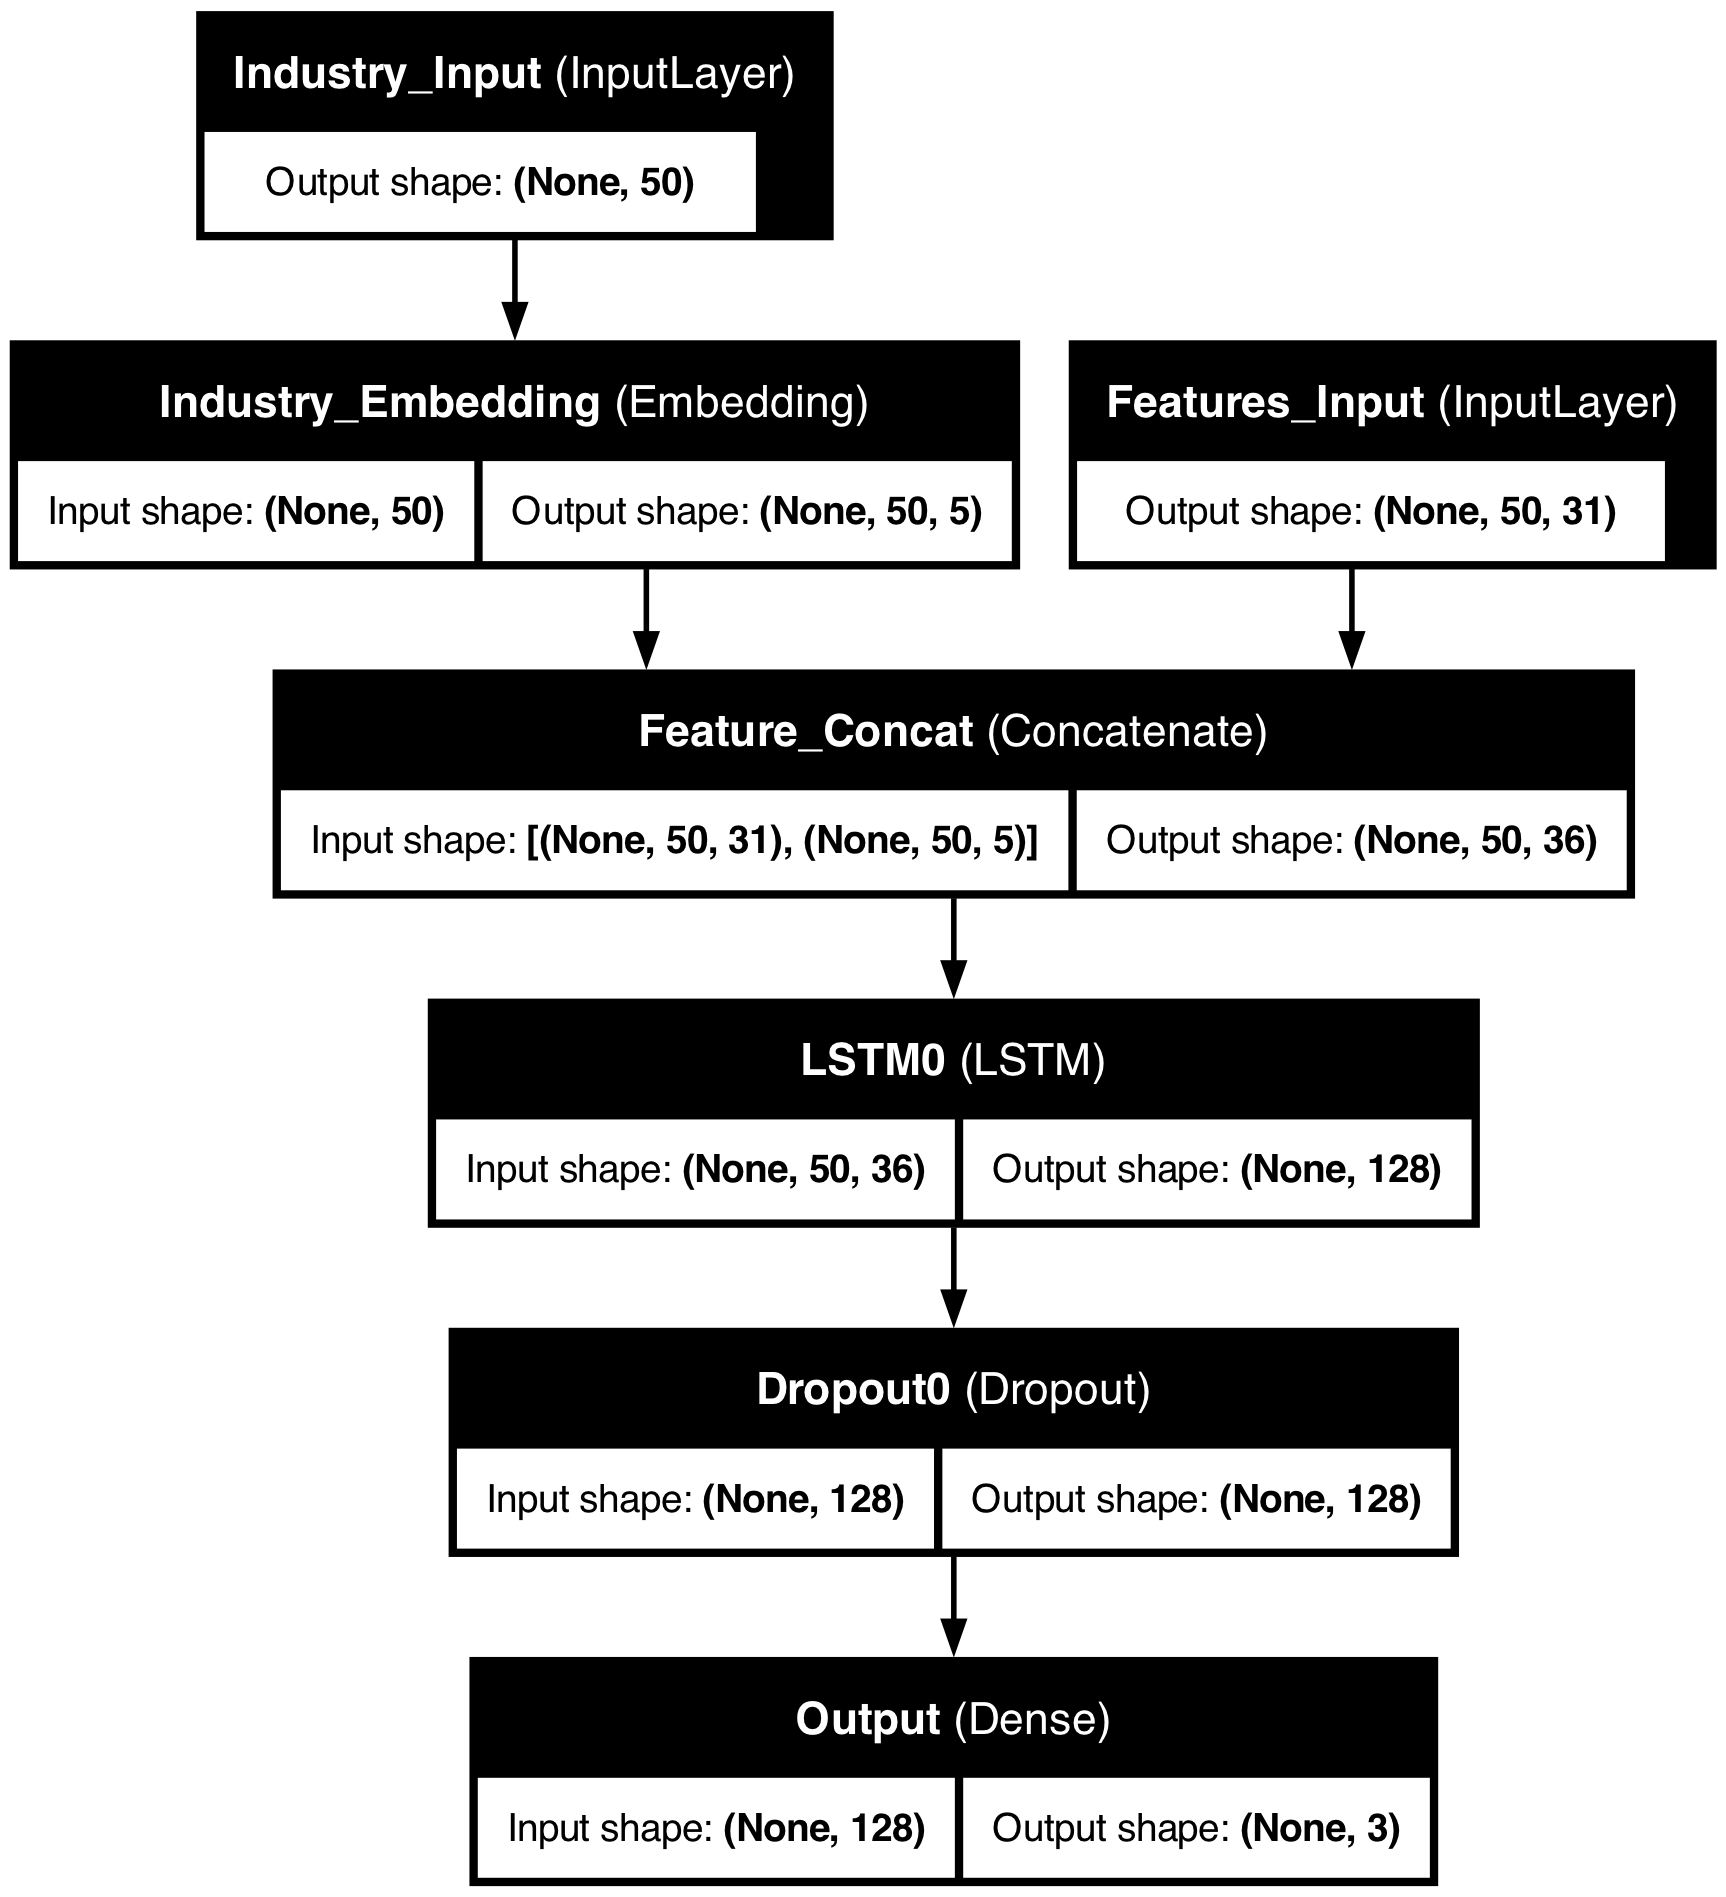

In [21]:
# Also getting the tf graph
display(plot_model(model_LSTM_base, show_shapes=True, show_layer_names=True))

In [22]:
# Fitting the model
model_LSTM_base_fit = model_LSTM_base.fit(
    x={"Features_Input": X_num_train, "Industry_Input": X_embed_train},
    y = Y_train,
    # validation_split = 0.005,
    epochs = num_epochs,
    batch_size = batch_size,
    verbose = 1)

Epoch 1/10


2025-05-01 10:21:33.843916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3708/3708 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.3778 - loss: 1.0865
Epoch 2/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.3927 - loss: 1.0732
Epoch 3/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.3971 - loss: 1.0713
Epoch 4/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.3979 - loss: 1.0705
Epoch 5/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.3989 - loss: 1.0699
Epoch 6/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.4012 - loss: 1.0694
Epoch 7/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.4021 - loss: 1.0689
Epoch 8/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.4031 - loss: 1.0686
Epoch 9/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.4041 - loss: 1.0682
Epoch 10/10
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - accuracy: 0.4049 - loss: 1.0678


While the accuracy still isn't great, this base run only took ~8 minutes (46 seconds per epoch) (compared to 40 minutes when using the CPU). I'll first check what the actual results look like for the rest run, but I'll likely incorporate the test data as validation data, and I'll use data from 2025 be my "true" test data.

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


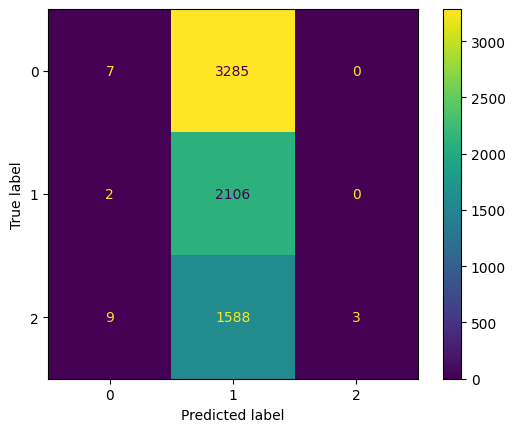

In [23]:
# Obtaining the test predictions
Y_test_base_pred = model_LSTM_base.predict(
  x={"Features_Input": X_num_test, "Industry_Input": X_embed_test})

# Setting a threshold of predictions and getting the confusion matrix
threshold = 0.5
Y_test_base_pred_thresh = np.where(Y_test_base_pred[:, 0] > threshold, 0,
                             np.where(Y_test_base_pred[:, 2] > threshold, 2, 1))

# Getting the confusion matrix for the threshold
cf_thresh = confusion_matrix(
    Y_test,
    Y_test_base_pred_thresh)
disp = ConfusionMatrixDisplay(cf_thresh.astype(int))
disp.plot()
plt.show()

So, it's clear that even across 7 days, with a threshold of 0.5, the model did not perform great. It barely took any trades, and the trades that it did take (especially on the short side) were quite wrong. This at least somewhat makes sense, as we no longer have the Open price in our data anymore, which was likely the biggest determinant of the prediction. However, I have not done any hyperparameter tuning, and it's likely the model can improve at least a bit. In particular, with the GPU, I can probably perform some more aggressive hyperparameter tuning to really improve the model (hidden layers, more LSTM layers, etc.).

## Hyperparameter-tuned model 1
This is my first iteration of hyperparameter tuning after switching to using the M4 Max Macbook's GPU for training.

In [23]:
# Setting seed for consistent re-runs
tf.random.set_seed(1234)
np.random.seed(1234)

# Setting hyperparameters
seq_length = X_data_small_num.shape[1]
num_features = X_data_small_num.shape[2]
n_classes = 3
num_industries = data_small['Industry_ID'].nunique()
embedding_dim = 12
LSTM_layers = 2
LSTM_units = 128
dropout_rate = 0.3
hidden_layer_sizes = [256, 128]
activation = 'relu'
learning_rate = 0.001
optimizer = 'Adam'
metric = 'accuracy'
num_epochs = 20
batch_size = 256
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [24]:
# Building the initial model
model_LSTM_hp_1 = build_LSTM_model_func_API_embed(seq_length=seq_length,
                                                  num_features=num_features,
                                                  n_classes=n_classes,
                                                  num_industries=num_industries,
                                                  embedding_dim=embedding_dim,
                                                  LSTM_layers=LSTM_layers,
                                                  LSTM_units=LSTM_units,
                                                  dropout_rate=dropout_rate,
                                                  hidden_layer_sizes=hidden_layer_sizes,
                                                  activation=activation,
                                                  learning_rate=learning_rate,
                                                  optimizer=optimizer,
                                                  metric=metric)
model_LSTM_hp_1.summary()

Model: "LSTM_Embed"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Industry_Input      │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Features_Input      │ (None, 50, 31)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Industry_Embedding  │ (None, 50, 12)    │        792 │ Industry_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Feature_Concat      │ (None, 50, 43)    │          0 │ Features_Input[0… │
│ (Concatenate)       │                   │            │ Industry_Embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM0 (LSTM)        │ (None, 50, 128)   │     88,064 │ Feature_Concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout0 (Dropout)  │ (None, 50, 128)   │          0 │ LSTM0[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 128)       │    131,584 │ Dropout0[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dropout1 (Dropout)  │ (None, 128)       │          0 │ LSTM1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hidden0 (Dense)     │ (None, 256)       │     33,024 │ Dropout1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HL_Dropout0         │ (None, 256)       │          0 │ Hidden0[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hidden1 (Dense)     │ (None, 128)       │     32,896 │ HL_Dropout0[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HL_Dropout1         │ (None, 128)       │          0 │ Hidden1[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 3)         │        387 │ HL_Dropout1[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 286,747 (1.09 MB)

 Trainable params: 286,747 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Fitting the model
model_LSTM_hp_1_fit = model_LSTM_hp_1.fit(
    x={"Features_Input": X_num_train, "Industry_Input": X_embed_train},
    y=Y_train,
    validation_data=({"Features_Input": X_num_test, "Industry_Input": X_embed_test}, Y_test),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[callback],
    verbose=1)

Epoch 1/20


2025-05-01 12:00:05.006973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


3708/3708 ━━━━━━━━━━━━━━━━━━━━ 71s 19ms/step - accuracy: 0.3770 - loss: 1.0870 - val_accuracy: 0.3297 - val_loss: 1.0849
Epoch 2/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 71s 19ms/step - accuracy: 0.3872 - loss: 1.0745 - val_accuracy: 0.3063 - val_loss: 1.0955
Epoch 3/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.3853 - loss: 1.0754 - val_accuracy: 0.3906 - val_loss: 1.0799
Epoch 4/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 71s 19ms/step - accuracy: 0.3840 - loss: 1.0771 - val_accuracy: 0.4190 - val_loss: 1.0688
Epoch 5/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.3835 - loss: 1.0779 - val_accuracy: 0.3311 - val_loss: 1.0944
Epoch 6/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.3835 - loss: 1.0797 - val_accuracy: 0.3499 - val_loss: 1.0805
Epoch 7/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 72s 19ms/step - accuracy: 0.3852 - loss: 1.0808 - val_accuracy: 0.4593 - val_loss: 1.0564
Epoch 8/20
3708/3708 ━━━━━━━━━━━━━━━━━━━━ 73s 20ms/step - accuracy: 0.3853 - loss: 1.08

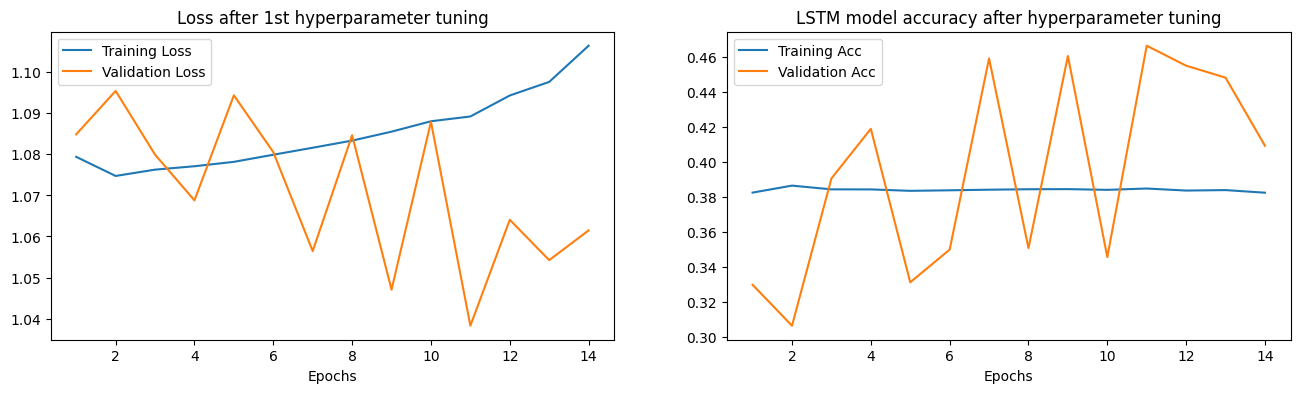

In [26]:
# Plotting the loss on the first subplot
hist_hp_1 = model_LSTM_hp_1_fit.history
epochs_ran = len(hist_hp_1['loss'])
fig = plt.figure(figsize = (16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(range(1, epochs_ran+1), hist_hp_1['loss'], label='Training Loss')
plt.plot(range(1, epochs_ran+1), hist_hp_1['val_loss'], label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('Loss after 1st hyperparameter tuning');

# Plotting the accuracy on the second subplot
ax = fig.add_subplot(1, 2, 2)
plt.plot(range(1, epochs_ran+1), hist_hp_1['accuracy'], label='Training Acc')
plt.plot(range(1, epochs_ran+1), hist_hp_1['val_accuracy'], label='Validation Acc')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_title('LSTM model accuracy after hyperparameter tuning')
plt.show()

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


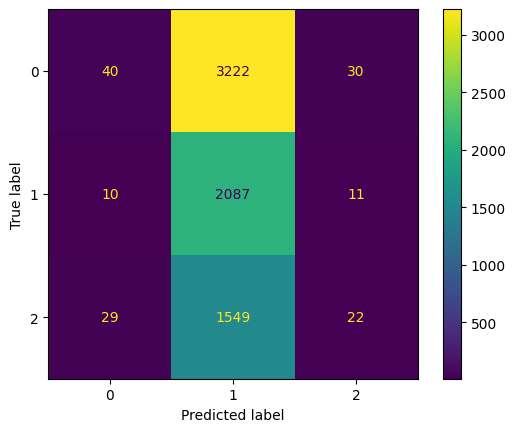

In [27]:
# Obtaining the test predictions
Y_test_hp_1_pred = model_LSTM_hp_1.predict(
  x={"Features_Input": X_num_test, "Industry_Input": X_embed_test})

# Setting a threshold of predictions and getting the confusion matrix
threshold = 0.50
Y_test_hp_1_pred_thresh = np.where(Y_test_hp_1_pred[:, 0] > threshold, 0,
                             np.where(Y_test_hp_1_pred[:, 2] > threshold, 2, 1))

# Getting the confusion matrix for the threshold
cf_thresh_hp_1 = confusion_matrix(
    Y_test,
    Y_test_hp_1_pred_thresh)
disp = ConfusionMatrixDisplay(cf_thresh_hp_1.astype(int))
disp.plot()
plt.show()

I tested with a number of different hyperparameter combinations, but I found this one to be particularly interesting. Notably, it was extremely choppy, and it didn't do well at all. More importantly, **the validation accuracy does not reflect how well the model does whatsoever**. This is primarily because it focuses on all the classes, not just Class 0 and 2 (which we care about). And since class 1 is so large, it gets the majority of the predictions.

There are two things I need to do now: 1) integrate the sliding window model to get a better representation of how well my model does across multiple days, and 2) figure out a way to weigh the errors on Class 0 and 2 more heavily; basically, if my model predicts 1, have it not worry much about whether it's right or wrong. However, if it predicts 0 or 2, it should be punished more heavily for getting it wrong. I'll also consider getting rid of the validation accuracy afterward as it's not giving me any valuable insight into model performance.

In [28]:
# Might need to do a weight thing where incorrect predictions that were "more incorrect" pecentage-wise should be weighted more heavily
# Honestly, might we worth doing linear regression and seeing how off we are when it comes to our predictions
# Though then we run into the problem of outliers affecting our predictions too much; so, maybe cap how far it's wrong?
# ...KL Divergence maybe??... Ok, maybe not, it's just cross-entropy minus entropy lol